# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [3]:

# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg, sum as Fsum
from pyspark.sql import Window
import datetime
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, \
    GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.linalg import SparseVector, DenseVector


In [4]:
# create a Spark session
# config parameter required in order to allow table creation
#  cf. https://stackoverflow.com/questions/54967186/cannot-create-table-with-spark-sql-hive-support-is-required-to-create-hive-tab
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .config("spark.sql.catalogImplementation","hive") \
    .getOrCreate()


# display Spark session info
spark.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1582682880276'),
 ('spark.sql.catalogImplementation', 'hive'),
 ('spark.driver.port', '34467'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.host', 'ac3d10d4028a')]

In [5]:
# display Spark version info
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [6]:
# load dataset
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)
user_log.createOrReplaceTempView("user_log_table")

In [7]:
# display dataset fields
spark.sql("DESC user_log_table").show()

+-------------+---------+-------+
|     col_name|data_type|comment|
+-------------+---------+-------+
|       artist|   string|   null|
|         auth|   string|   null|
|    firstName|   string|   null|
|       gender|   string|   null|
|itemInSession|   bigint|   null|
|     lastName|   string|   null|
|       length|   double|   null|
|        level|   string|   null|
|     location|   string|   null|
|       method|   string|   null|
|         page|   string|   null|
| registration|   bigint|   null|
|    sessionId|   bigint|   null|
|         song|   string|   null|
|       status|   bigint|   null|
|           ts|   bigint|   null|
|    userAgent|   string|   null|
|       userId|   string|   null|
+-------------+---------+-------+



In [8]:

# display a few sample records
spark.sql("SELECT * FROM user_log_table LIMIT 5").collect()

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [9]:
# count number of records
spark.sql("SELECT COUNT(*) AS totalEntries FROM user_log_table").show()

+------------+
|totalEntries|
+------------+
|      286500|
+------------+



In [10]:
# are there any null userId or sessionId?
spark.sql("SELECT COUNT(*) AS totalNullEntries FROM user_log_table WHERE userId IS NULL OR sessionId IS NULL").show()

+----------------+
|totalNullEntries|
+----------------+
|               0|
+----------------+



In [11]:

# display userIds
spark.sql("SELECT DISTINCT userId FROM user_log_table ORDER BY userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [12]:
# only keep userIds which are not empty and count them
user_log_valid = spark.sql("SELECT * FROM user_log_table WHERE userId != ''")
user_log_valid.createOrReplaceTempView("user_log_valid_table")
spark.sql("SELECT COUNT(*) AS totalValidEntries FROM user_log_valid_table").show()

+-----------------+
|totalValidEntries|
+-----------------+
|           278154|
+-----------------+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [13]:
# is there any status different from 'free' or 'paid'?
spark.sql("SELECT COUNT(*) FROM user_log_valid_table WHERE status<>'free' AND status<>'paid'").show()

+--------+
|count(1)|
+--------+
|       0|
+--------+



In [14]:
# display all visited pages
spark.sql("SELECT DISTINCT page FROM user_log_valid_table ORDER BY page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [15]:
# display logged actions for a sample user
spark.sql("SELECT sessionId, page, song FROM user_log_valid_table WHERE userId = '42' ORDER BY sessionId, itemInSession").show(50)

+---------+---------------+--------------------+
|sessionId|           page|                song|
+---------+---------------+--------------------+
|      291|           Home|                null|
|      304|           Home|                null|
|      304|       NextSong|Maybe I'll Come Down|
|      304|       NextSong|         Burndt Jamb|
|      304|      Thumbs Up|                null|
|      304|       NextSong|             Soldier|
|      304|       NextSong|        Make Her Say|
|      304|       NextSong|Adventures In A Y...|
|      304|       NextSong|      Sweet About Me|
|      304|       NextSong|From Across The W...|
|      304|       NextSong|The Spirits Withi...|
|      304|       NextSong|You Ain't Seen No...|
|      304|       NextSong|       She Loves You|
|      304|      Thumbs Up|                null|
|      304|       NextSong|    Deeply Disturbed|
|      304|       NextSong|   Health And Wealth|
|      304|    Roll Advert|                null|
|      304|       Ne

In [16]:
# can we have different lengths for the same song? 'nonzero' captures these cases
spark.sql('''SELECT COUNT(*) AS total,
    SUM (CASE WHEN diff = 0 THEN 1 ELSE 0 END) zero,
    SUM (CASE WHEN diff != 0 THEN 1 ELSE 0 END) nonzero
    FROM (SELECT artist, song, MAX(length)-MIN(length) AS diff
        FROM user_log_valid_table
        WHERE song IS NOT NULL
        GROUP BY artist, song)''').show()

+-----+-----+-------+
|total| zero|nonzero|
+-----+-----+-------+
|65416|64903|    513|
+-----+-----+-------+



In [17]:

# do users have possibility to skip a song?
# This is done by measuring time difference between two 'NextSong' pages for the same user and session,
# and comparing it with song length; in case a song could be skipped, this should be returned as a result below
spark.sql('''SELECT a.length, (MIN(b.ts)-a.ts)/1000-a.length AS diff
    FROM user_log_valid_table a
    INNER JOIN user_log_valid_table b
        ON (b.userId = a.userId AND b.sessionId = a.sessionId AND b.page = "NextSong" AND b.ts > a.ts)
    WHERE a.page = "NextSong"
    GROUP BY a.userId, a.sessionId, a.ts, a.length
    HAVING diff < -1''').show()

+------+----+
|length|diff|
+------+----+
+------+----+



In [18]:
# how often does a user visit each page?
spark.sql('''SELECT page, MAX(cnt) maxCount
    FROM (SELECT userId, page, COUNT(*) cnt
        FROM user_log_valid_table
        GROUP BY userId, page)
    GROUP BY page
    ORDER BY page''').show()

+--------------------+--------+
|                page|maxCount|
+--------------------+--------+
|               About|      25|
|          Add Friend|     143|
|     Add to Playlist|     240|
|              Cancel|       1|
|Cancellation Conf...|       1|
|           Downgrade|      73|
|               Error|       7|
|                Help|      46|
|                Home|     355|
|              Logout|     124|
|            NextSong|    8002|
|         Roll Advert|     128|
|       Save Settings|      10|
|            Settings|      52|
|    Submit Downgrade|       3|
|      Submit Upgrade|       4|
|         Thumbs Down|      75|
|           Thumbs Up|     437|
|             Upgrade|      15|
+--------------------+--------+



In [19]:
# get max timestamp (this is to compute timeRegistered below)
max_ts = spark.sql("SELECT MAX(ts) FROM user_log_valid_table").collect()[0][0]

In [21]:

# we build several temporary tables: first users_pages captures count of users' visits of relevant pages
users_pages = spark.sql('''CREATE TABLE users_pages_table2 AS
    (SELECT DISTINCT(userId),
    (SELECT COUNT(*) FROM user_log_valid_table b WHERE b.page="Cancellation Confirmation" AND b.userId=a.userId) AS churned,
    (SELECT (CASE WHEN COUNT(*)>0 THEN 1 ELSE 0 END) FROM user_log_valid_table b WHERE b.page="Submit Downgrade" AND b.userId=a.userId) AS downgraded,
    (SELECT (CASE WHEN COUNT(*)>0 THEN 1 ELSE 0 END) FROM user_log_valid_table b WHERE b.page="Submit Upgrade" AND b.userId=a.userId) AS upgraded,
    (SELECT COUNT(*) FROM user_log_valid_table b WHERE b.page="NextSong" AND b.userId=a.userId) AS nbSongs,
    (SELECT COUNT(*) FROM user_log_valid_table b WHERE b.page="Roll Advert" AND b.userId=a.userId) AS nbAdverts,
    (SELECT COUNT(*) FROM user_log_valid_table b WHERE b.page="Thumbs Up" AND b.userId=a.userId) AS thumbsUp,
    (SELECT COUNT(*) FROM user_log_valid_table b WHERE b.page="Thumbs Down" AND b.userId=a.userId) AS thumbsDown,
    (SELECT COUNT(*) FROM user_log_valid_table b WHERE b.page="Add to Playlist" AND b.userId=a.userId) AS addToPlaylist,
    (SELECT COUNT(*) FROM user_log_valid_table b WHERE b.page="Add Friend" AND b.userId=a.userId) AS addFriend
    FROM user_log_valid_table a)''')

In [22]:

# then users_agents captures users' operating systems
users_agents = spark.sql('''CREATE TABLE users_agents_table2 AS
    (SELECT DISTINCT(userId),
    (SELECT (CASE WHEN COUNT(*)>0 THEN 1 ELSE 0 END) FROM user_log_valid_table b WHERE b.userId=a.userId AND userAgent LIKE '%Windows%') AS windows,
    (SELECT (CASE WHEN COUNT(*)>0 THEN 1 ELSE 0 END) FROM user_log_valid_table b WHERE b.userId=a.userId AND userAgent LIKE '%Mac%') AS mac,
    (SELECT (CASE WHEN COUNT(*)>0 THEN 1 ELSE 0 END) FROM user_log_valid_table b WHERE b.userId=a.userId AND userAgent LIKE '%Linux%') AS linux
    FROM user_log_valid_table a)''')

In [23]:
# then users_others captures other relevant fields (gender, level, timeRegisterd, nbSessions)
users_others = spark.sql('''CREATE TABLE users_others_table2 AS
    (SELECT DISTINCT(userId),
    (SELECT (CASE WHEN FIRST(gender)='M' THEN 0 ELSE 1 END) gender FROM user_log_valid_table b WHERE b.userId=a.userId) AS gender,
    (SELECT (CASE WHEN LAST(level)='free' THEN 0 ELSE 1 END) FROM user_log_valid_table b WHERE b.userId=a.userId) AS level,
    (SELECT ('''+str(max_ts)+'''-FIRST(registration))/1000/60/60 FROM user_log_valid_table b WHERE b.userId=a.userId) AS timeRegistered,
    (SELECT COUNT(DISTINCT(sessionId)) FROM user_log_valid_table b WHERE b.userId=a.userId) AS nbSessions
    FROM user_log_valid_table a)''')

In [24]:
# we now combine all three temporary tables to get the features that will be used by our model
# and also export results in a Pandas dataframe
users = spark.sql('''SELECT churned, downgraded, upgraded, nbSongs/nbSessions AS nbSongsPerSession,
    nbAdverts/nbSessions AS nbAdvertsPerSession, thumbsUp/nbSongs AS thumbsUpPerSong,
    thumbsDown/nbSongs AS thumbsDownPerSong, addToPlaylist/nbSongs AS addToPlaylistPerSong,
    addFriend/nbSessions AS addFriendsPerSession, windows, mac, linux, gender, level, timeRegistered
    FROM users_pages_table2 a, users_agents_table2 b, users_others_table2 c
    WHERE a.userId = b.userId AND b.userId = c.userId''')
users.createOrReplaceTempView("users_table")
users_df = users.toPandas()

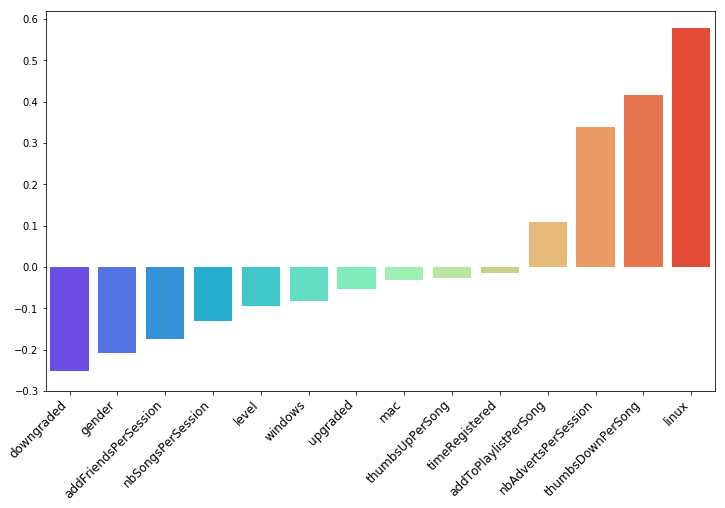

In [25]:

# to analyze our features, we define a basic score as:
# score = average for churned users - average for non-churned users
#       / max (average for churned users, average for non-churned users)
# we plot it for the features we retained
cmp_df = users_df.groupby(['churned']).mean()
for i in cmp_df.columns:
    cmp_df.at['diff',i] = cmp_df[i][1]-cmp_df[i][0]
    cmp_df.at['diff',i] /= max(cmp_df[i][0],cmp_df[i][1])
cmp_df.drop([0,1],inplace=True)
cmp_df.sort_values(by=['diff'],axis=1,inplace=True)

# https://www.drawingfromdata.com/how-to-rotate-axis-labels-in-seaborn-and-matplotlib
plt.figure(figsize=(12,7))
chart = sns.barplot(data=cmp_df,palette='rainbow')
chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontsize='large'
)
chart.set_yticks(np.arange(-0.3,0.61,0.1))
plt.show()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [27]:
csv_path = 'features.csv'
# we now write the output in a CSV file so that we don't need to repeat the above steps
users.write.mode('overwrite').save(csv_path, format='csv', header=True)
# we can now remove our temporary tables
spark.sql("DROP TABLE users_pages_table2")
spark.sql("DROP TABLE users_agents_table2")
spark.sql("DROP TABLE users_others_table2")


DataFrame[]

In [29]:
# load features from file; inferSchema option is required to retrieve numbers rather than strings
users = spark.read.csv(csv_path, header=True, inferSchema = True)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [31]:

# extract prediction columns (all except 'churned'), and split data into train and test sets
pred_cols = users.columns
pred_cols.remove('churned')
train, test = users.randomSplit([0.75, 0.25],seed=123)

In [32]:

# create assembler and scaler for our pipeline; we choose F1 score for evaluator as suggested
assembler = VectorAssembler(inputCols=pred_cols, outputCol='assembled')
scaler = StandardScaler(inputCol='assembled', outputCol='scaled')
evaluator = MulticlassClassificationEvaluator(labelCol='churned', predictionCol='prediction', metricName='f1')
scores = []

In [33]:
# create pipeline with logistic regression classifier, using default settings, train model and measure score against test
logistic_regression_classifier = LogisticRegression(featuresCol='scaled', labelCol='churned')
pipeline = Pipeline(stages=[assembler, scaler, logistic_regression_classifier])
model = pipeline.fit(train)
preds = model.transform(test)
scores.append(['Logistic Regression', evaluator.evaluate(preds)])

In [34]:
# same for decision tree
decision_tree_classifier = DecisionTreeClassifier(featuresCol='scaled', labelCol='churned')
pipeline = Pipeline(stages=[assembler, scaler, decision_tree_classifier])
model = pipeline.fit(train)
preds = model.transform(test)
scores.append(['Decision Tree', evaluator.evaluate(preds)])

In [35]:
# and random forest
random_forest_classifier = RandomForestClassifier(featuresCol='scaled', labelCol='churned')
pipeline = Pipeline(stages=[assembler, scaler, random_forest_classifier])
model = pipeline.fit(train)
preds = model.transform(test)
scores.append(['Random Forest', evaluator.evaluate(preds)])

In [36]:

# and GBT
gbt_classifier = GBTClassifier(featuresCol='scaled', labelCol='churned')
pipeline = Pipeline(stages=[assembler, scaler, gbt_classifier])
model = pipeline.fit(train)
preds = model.transform(test)
scores.append(['GBT', evaluator.evaluate(preds)])

In [37]:
# and linear SVC
linear_svc_classifier = LinearSVC(featuresCol='scaled', labelCol='churned')
pipeline = Pipeline(stages=[assembler, scaler, linear_svc_classifier])
model = pipeline.fit(train)
preds = model.transform(test)
scores.append(['Linear SVC', evaluator.evaluate(preds)])

In [38]:
# and naive Bayes
naive_bayes_classifier = NaiveBayes(featuresCol='scaled', labelCol='churned')
pipeline = Pipeline(stages=[assembler, scaler, naive_bayes_classifier])
model = pipeline.fit(train)
preds = model.transform(test)
scores.append(['Naive Bayes', evaluator.evaluate(preds)])

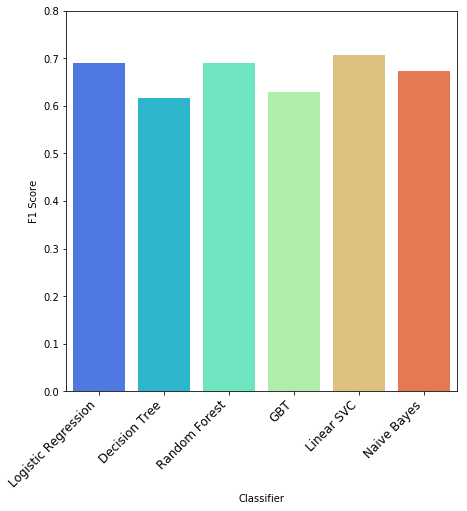

In [39]:

# we can now plot scores for all models and compare them
scores_df = pd.DataFrame(scores,columns=['Classifier', 'F1 Score'])
plt.figure(figsize=(7,7))
chart = sns.barplot(x='Classifier',y='F1 Score',data=scores_df,palette='rainbow')
chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontsize='large'
)
chart.set_yticks(np.arange(0,0.81,0.1))
plt.show()

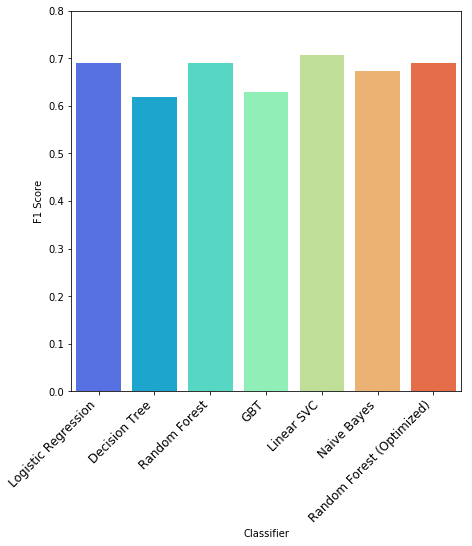

In [40]:
# let's now try to fine tune parameters for our random forest model using a grid search
# then plot the results
pipeline = Pipeline(stages=[assembler, scaler, random_forest_classifier])

param_grid = ParamGridBuilder()\
.addGrid(random_forest_classifier.maxDepth, [3,5,10])\
.addGrid(random_forest_classifier.maxBins, [16,32,48])\
.addGrid(random_forest_classifier.numTrees, [20,30,40])\
.build()

cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps = param_grid, 
                    evaluator = evaluator,
                    numFolds=4)
model = cv.fit(train)
preds = model.transform(test)
scores.append(['Random Forest (Optimized)', evaluator.evaluate(preds)])
scores_df = pd.DataFrame(scores,columns=['Classifier', 'F1 Score'])
plt.figure(figsize=(7,7))
chart = sns.barplot(x='Classifier',y='F1 Score',data=scores_df,palette='rainbow')
chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontsize='large'
)
chart.set_yticks(np.arange(0,0.81,0.1))
plt.show()

In [41]:
# same in table format
scores_df

,Classifier,F1 Score
0,Logistic Regression,0.690670
1,Decision Tree,0.617591
2,Random Forest,0.690670
3,GBT,0.628548
4,Linear SVC,0.707475
5,Naive Bayes,0.673224
6,Random Forest (Optimized),0.690670


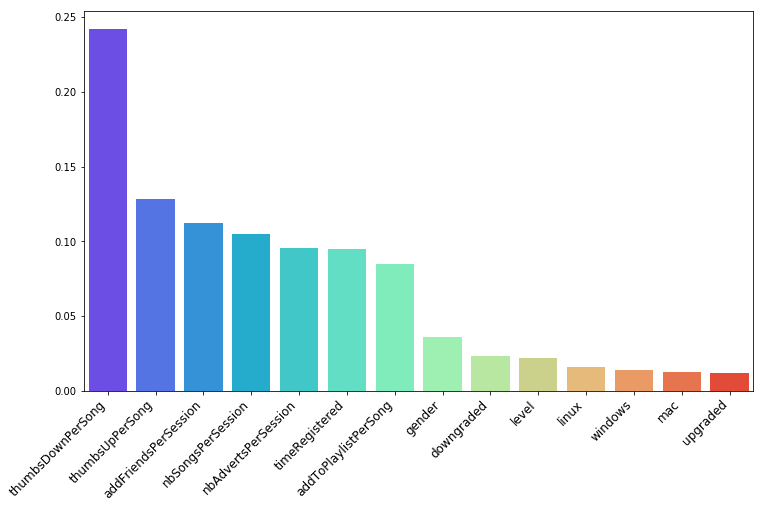

In [42]:
# now let's retrieve feature importance for our optimized model and plot them
feat_imp = DenseVector(model.bestModel.stages[2].featureImportances).values

# http://scienceoss.com/sort-one-list-by-another-list/
feat_imp_sorted = np.array(feat_imp)
pred_cols_sorted = np.array(pred_cols)
inds = np.flipud(feat_imp_sorted.argsort())
pred_cols_sorted = pred_cols_sorted[inds]
feat_imp_sorted = feat_imp_sorted[inds]

plt.figure(figsize=(12,7))
chart = sns.barplot(x=pred_cols_sorted,y=feat_imp_sorted,palette='rainbow')
chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontsize='large'
)
plt.show()

In [43]:
# parameters used for our default random forest classifier
random_forest_classifier.extractParamMap()

{Param(parent='RandomForestClassifier_61baa537da73', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities.'): 'probability',
 Param(parent='RandomForestClassifier_61baa537da73', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name.'): 'rawPrediction',
 Param(parent='RandomForestClassifier_61baa537da73', name='seed', doc='random seed.'): -5657253821140074564,
 Param(parent='RandomForestClassifier_61baa537da73', name='predictionCol', doc='prediction column name.'): 'prediction',
 Param(parent='RandomForestClassifier_61baa537da73', name='labelCol', doc='label column name.'): 'churned',
 Param(parent='RandomForestClassifier_61baa537da73', name='featuresCol', doc='features column name.'): 'scaled',
 Param(parent='RandomForestClassifier_61baa537da73', name='maxDepth', doc='Maximum depth of 

In [44]:
# parameters used for our optimized random forest classifier
model.bestModel.stages[2].extractParamMap()

{Param(parent='RandomForestClassifier_61baa537da73', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestClassifier_61baa537da73', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestClassifier_61baa537da73', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto',
 Param(parent='RandomForestClassifier_61baa537da73', name='featuresCol', doc='features column name'): 'scaled',
 Param(parent='RandomForestClassifier_61baa537da73', na

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.